In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite

from math import factorial
from qlp.mds.graph_tools import generate_nn_graph

In [99]:

def generate_limited_corona_graph(k: int, n: int):
    """Returns edges of a n-shortcut 3k-ring graph with broken rotational symmetry.

    Has unique ground state solution with increased connectivity
    For limited corona, the shortcuts are added to keep max connections / vertex the smallest

    Arguments:
        k: number of 3 vertex segments
        n: number of shortcuts. 
    """

    if n >= factorial(3*k-2):
        raise ValueError("n >= (3k-2)!: More shortcuts than allowed for graph.\n Choose a smaller number.")
    
    # construct base ring
    ring, _ = generate_nn_graph(3*k)
    ring.add((3*k-1, 0))

    # add antigen
    antigen = ((3*i+1,3*k+i) for i in range(k))
    ring.update(antigen)

    # connectivity
    connections = {idx: 2 for idx in range(3*k)}
    for i in range(k):
        connections[3*i+1] += 1

    # add shortcuts
    shortcuts = [(kidx, (kidx+nidx+2)%(3*k)) for nidx in range(k) for kidx in range(3*k)]
    count = 0
    minconnections = min(connections.values())
    while count < n:
        for idx, shortcut in enumerate(shortcuts):
            start = shortcut[0]
            end = shortcut[1]
            if connections[start] > minconnections or connections[end] > minconnections:
                deadend = True
                pass
            else:
                ring.add(shortcut)
                shortcuts.pop(idx)
                connections[start] += 1
                connections[end] +=1
                minconnections = min(connections.values())
                count += 1
                deadend = False
                break
        if idx == len(shortcuts)-1 and deadend:
            minconnections += 1
    return ring, f"lC19({k},{n})"

2
4
4
{0: 4, 1: 5, 2: 4, 3: 4, 4: 5, 5: 4}
14


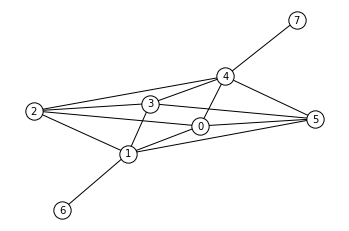

In [101]:
graph, tag = generate_limited_corona_graph(2, 6)
print(len(graph))
gt.get_plot(graph, directed=False)
plt.show()